# Classical Net (CNet) Unit Test on GHZ State
The goal of this notebook is to construct a first step in the classical component of the hybrid quantum net. Ultimately, the classical net (CNet) should be able to take the parametrization of the quantum circuit as input and output the desired loss metric to a high degree of accuracy. As a first round, instead of giving the parameters, we will give the actual probability distributions themselves and see if it can learn the metric from the distributions. This is generally an easier problem since the distbution gives maximal information.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random
from math import pi
%matplotlib inline

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
import torch as t
from torch.nn import functional as F
from __helpers import qubit_expansion
from __loss_funcs import KL
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_CNet import CNet


## Construction of the State

In [7]:
STATE_TYPE = 'GHZ'
if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**3)
    qc = GHZ_state_circuit()
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(3) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(3).numpy()) # L = 3 qubits
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(3) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**9)
    qc = cluster_state_circuit(3)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")

         ┌───┐          
q2146_0: ┤ H ├──■────■──
         └───┘┌─┴─┐  │  
q2146_1: ─────┤ X ├──┼──
              └───┘┌─┴─┐
q2146_2: ──────────┤ X ├
                   └───┘


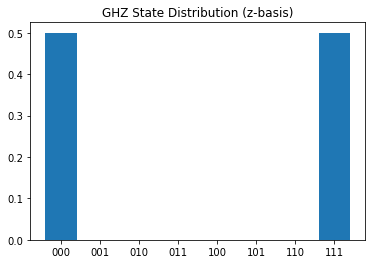

In [8]:
# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.title(f"{STATE_TYPE} State Distribution (z-basis)")
plt.show()

## Example of Basis Transformation

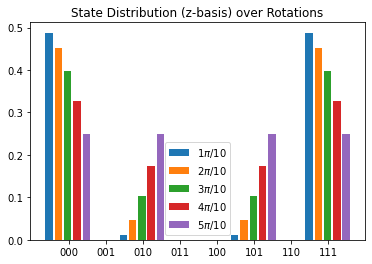

In [9]:
# Example: change of basis with 5 uniform Pi/10 rotations.
basis_p = t.zeros(3,3) # generally L x 3
fig, ax = plt.subplots()
for i in range(5):
    basis_p[1,0] += pi/10
    # print(f"[{i+1}/5] Parameter matrix:\n", parameter)
    dist_i = BasisTransformer([state], basis_p).updated_dist()[0]
    bar = ax.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.175*state.num_qubits, dist_i, width=0.2)
    bar.set_label(rf"${i+1}\pi/10$")
plt.legend()
ax.set_xticks(np.arange(2**state.num_qubits))
ax.set_xticklabels(qubit_expansion(state.num_qubits))
plt.title("State Distribution (z-basis) over Rotations")
plt.show()

## Classical Deep Neural Net Construction
We will use Pyt for the neural net implementation.
Potential architectures:
1. Feed-forward: very simple, but possibly ineffective.
2. Convolutional: simple, respects 1-local structure of the qubit change-of-basis.
3. Variational autoencoder: used to project distributions, but no clear generalization to learn-by-parameters in place of learn-by-distribution.

## CNet Training on State
We generate the train and test input data, and train the CNet to learn the metric.

=== Basis 1/2 ===
Parametrized quantum circuit (noise: 0) initialized.
torch.Size([3000, 28])
Classical deep net of circuit depth 2 initialized.
[CNet] Training 3000 points...
Training....
Training error: 0.13834
Cross-validation error: 1.52523

=== Basis 2/2 ===
Parametrized quantum circuit (noise: 0) initialized.
torch.Size([3000, 28])
Classical deep net of circuit depth 2 initialized.
[CNet] Training 3000 points...
Training....
Training error: 0.03521
Cross-validation error: 1.23691



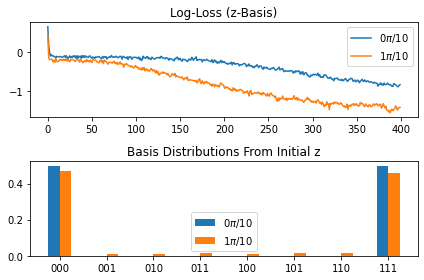

In [10]:
# Train one with a rotation of 0, one with Pi/10
X_BASIS = False
DEPTH = 2
num_bases = 2
basis_p = t.zeros(state.num_qubits, 3) # z-basis
if X_BASIS:
    basis_p[:,0] = t.ones(3) * pi/2 # x-basis
fig, (ax1, ax2) = plt.subplots(nrows=2)
for i in range(num_bases):
    print(f"=== Basis {i+1}/{num_bases} ===")
    train_data, test_data = PQC(state, basis_p, depth=DEPTH).generate_train_test()
    print(train_data.shape)
    net = CNet(state.num_qubits, depth=DEPTH)
    losses = net.train(train_data, nepoch=4000, eta=1e-2, print_log=True)

    ax1.plot(np.arange(len(losses)), np.log10(losses), label=fr'{i}$\pi/10$')

    dist_i = BasisTransformer([state], basis_p).updated_dist()[0]
    bar = ax2.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.125, dist_i, width=0.25)
    bar.set_label(fr"${i}\pi/10$")
    print("Training error: %2.5f"%np.mean(losses[-10:-1]))
    
    cv_err = net.test(test_data)
    print("Cross-validation error: %2.5f\n"%cv_err)
    
    basis_p[:,0] += pi/10 * t.ones(3) # change the basis param for next iteration of loop
ax1.legend(); ax2.legend()
ax2.set_xticks(np.arange(2**state.num_qubits))
ax2.set_xticklabels(qubit_expansion(state.num_qubits))
ax1.set_title(f'Log-Loss ({"x" if X_BASIS else "z"}-Basis)')
ax2.set_title(f'Basis Distributions From Initial {"x" if X_BASIS else "z"}')
fig.tight_layout()
plt.show()